In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc)
from sklearn.neighbors import NearestCentroid
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

data = pd.read_csv(r"C:\Users\Superuser\Desktop\Datasets\Loan_default.csv")

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

It is a rather large dataset; +24MB will subset data to n=3000 samples for uploading  

In [10]:
data = data.sample(n=3000, random_state=42).copy()

## Feature Selection

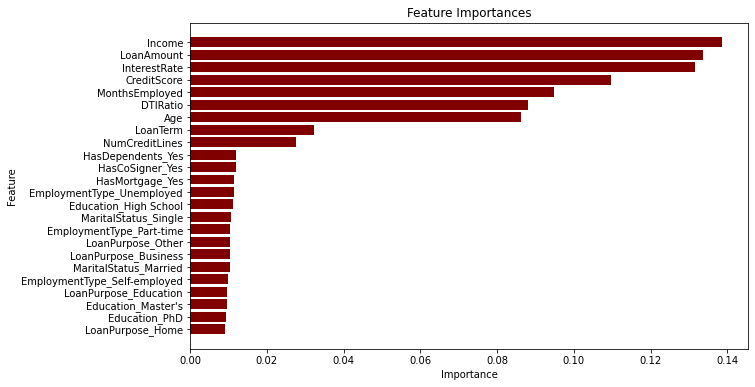

In [23]:
data = data.copy()

# Separate features (X) and target variable (y)
#ID is just a unique tag per loan, irrelavent 

X = data.drop(['Default', 'LoanID'], axis=1)
y = data['Default']

# Because we are trying to find the most significant correlations with another categorical variable ('Default'), it is very important to ensure we encode our categorical to ensure accurate feature selection. 
# One-hot encode all object (categorical) columns
X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)


rf_regressor = RandomForestRegressor(n_estimators=10, random_state=42)
rf_regressor.fit(X_encoded, y)
feature_importances = rf_regressor.feature_importances_


importance_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='maroon')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


Choosing Features with importance > 0.03

In [24]:
X = data[['InterestRate', 'Income', 'LoanAmount', 'Age', 'CreditScore',
          'MonthsEmployed', 'DTIRatio', 'LoanTerm', 'NumCreditLines']]
y = data['Default']


In [25]:
y.value_counts(normalize=True)

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64

The classes are heavily unbalanced and will heavily skew the results. This MUST be addressed in order to accurately predict our target 'Default' variable.
Applying Synthetic Minority Over-Sampling Technique SMOTE

In [26]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Now both classes are of equal proportion

In [27]:
y_resampled.value_counts(normalize=True)

Default
0    0.5
1    0.5
Name: proportion, dtype: float64

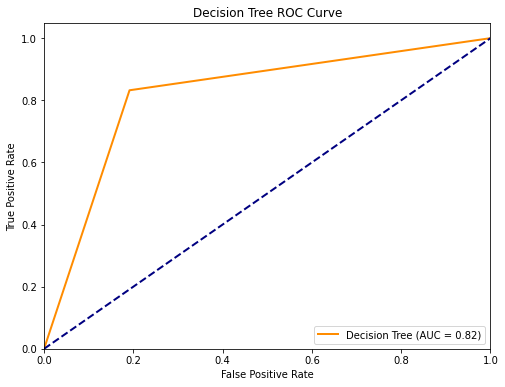

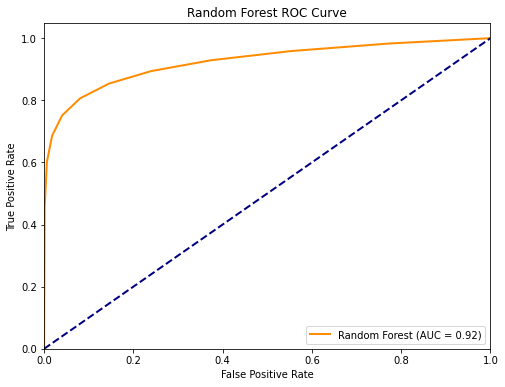

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42, probability=True),  # Enable probability estimates
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(n_estimators=10, random_state=42),
    
}

# Initialize dictionaries to store evaluation metric results
results = {
    'Classifier': [],
    'Accuracy': [],
    'F1 Score': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC': []
}

# Loop through classifiers and calculate various evaluation metrics using cross-validation
for classifier_name, classifier in classifiers.items():
    y_scores = cross_val_predict(classifier, X_scaled, y_resampled, cv=5, method='predict_proba')[:, 1]
    
    accuracy_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='accuracy')
    f1_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='f1')
    precision_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='precision')
    recall_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='recall')
    roc_auc_scores = cross_val_score(classifier, X_scaled, y_resampled, cv=5, scoring='roc_auc')
    
    # Take the mean of cross-validation scores
    accuracy_mean = np.mean(accuracy_scores)
    f1_mean = np.mean(f1_scores)
    precision_mean = np.mean(precision_scores)
    recall_mean = np.mean(recall_scores)
    roc_auc_mean = np.mean(roc_auc_scores)
    
    results['Classifier'].append(classifier_name)
    results['Accuracy'].append(accuracy_mean)
    results['F1 Score'].append(f1_mean)
    results['Precision'].append(precision_mean)
    results['Recall'].append(recall_mean)
    results['ROC AUC'].append(roc_auc_mean)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_resampled, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{classifier_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Create line plots to compare evaluation metrics
plt.figure(figsize=(12, 6))
for metric_name, metric_results in {
    'Accuracy': results['Accuracy'],
    'F1 Score': results['F1 Score'],
    'Precision': results['Precision'],
    'Recall': results['Recall'],
    'ROC AUC': results['ROC AUC']
}.items():
    plt.plot(results['Classifier'], metric_results, label=metric_name, marker='o')

plt.xlabel('Classifiers')
plt.ylabel('Score')
plt.title('Classifier Comparison (Cross-Validation)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


results_df = pd.DataFrame(results)
print(results_df)


Among the classifiers evaluated, the Random Forest classifier stands out as the best performer in terms of overall accuracy, achieving an impressive 88.86%, and also excelling in F1 score, precision, recall, and ROC AUC with values of 88.47%, 88.10%, 89.54%, and 95.87% respectively. It showcases the highest balance between precision and recall, making it a robust choice for this classification task. In contrast, the SVM classifier demonstrates the lowest accuracy at 70.56% and falls behind in F1 score, precision, and ROC AUC, indicating its suboptimal performance. The k-NN classifier, while having a relatively lower accuracy of 81.63%, stands out for its remarkable recall of 97.34%, suggesting its suitability when prioritizing identifying true positives. Ultimately, the XGBoost classifier proves to be the greatest all-rounder, achieving the highest F1 score of 88.88% and excelling in precision, recall, and ROC AUC, making it a versatile choice for various scenarios.